In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 80.9 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from math import sqrt
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:

df = pd.read_csv('SSI Historical Data.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1249 non-null   object 
 1   Price     1249 non-null   float64
 2   Open      1249 non-null   float64
 3   High      1249 non-null   float64
 4   Low       1249 non-null   float64
 5   Vol.      1249 non-null   float64
 6   Change %  1249 non-null   float64
dtypes: float64(6), object(1)
memory usage: 68.4+ KB


In [4]:

dataset=df.loc[:,["Date","Price"]]
dataset.tail()

,Date,Price
1244,11/25/2022,17100.0
1245,11/28/2022,18250.0
1246,11/29/2022,18950.0
1247,11/30/2022,19250.0
1248,12/1/2022,18200.0


In [5]:
dataset.head()

,Date,Price
0,12/1/2017,13928.5
1,12/4/2017,14712.2
2,12/5/2017,14257.2
3,12/6/2017,14130.8
4,12/7/2017,13701.0


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1249 non-null   object 
 1   Price   1249 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.6+ KB


In [7]:
dataset.describe()

,Price
count,1249.000000
mean,19021.627142
std,10081.046795
min,6264.400000
25%,11630.000000
50%,15445.300000
75%,21260.800000
max,49668.900000


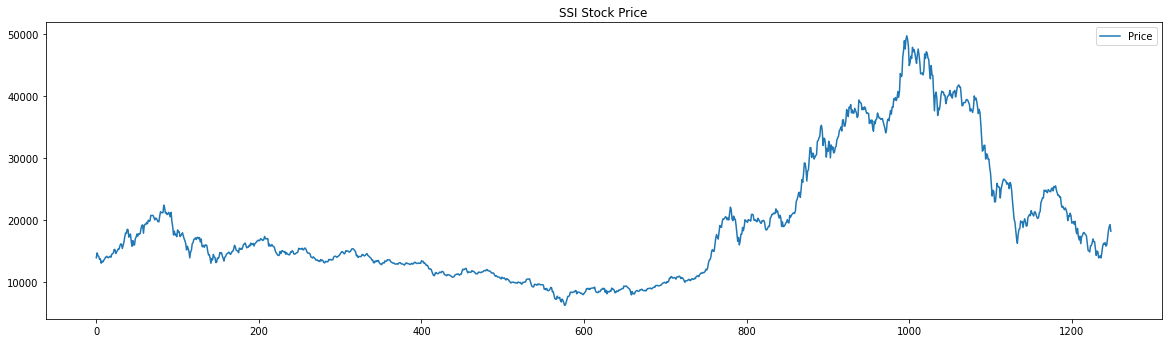

In [8]:
plt.figure(figsize=(20,12))
plt.subplot(2, 1, 1)
plt.title('SSI Stock Price')
plt.plot(df.Price,label='Price')
plt.legend()


In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [10]:
adf_test(df['Price'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -1.304006
p-value                    0.627338
# lags used                5.000000
# observations          1243.000000
critical value (1%)       -3.435622
critical value (5%)       -2.863868
critical value (10%)      -2.568009
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [11]:
auto_arima(df['Price'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1249
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -9776.402
Date:                Wed, 04 Jan 2023   AIC                          19554.805
Time:                        23:36:06   BIC                          19559.934
Sample:                             0   HQIC                         19556.733
                               - 1249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.727e+05   8332.811     44.731      0.000    3.56e+05    3.89e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.11   Jarque-Bera (JB):              1010.79
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               6.17   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

[Text(0, 0.5, 'Stock Price'), Text(0.5, 0, '')]

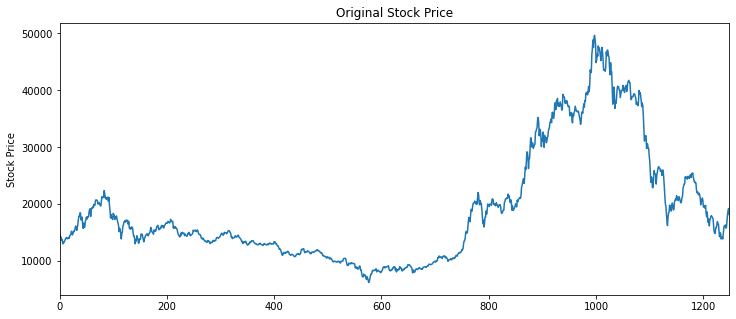

In [12]:
title = 'Original Stock Price'
ylabel='Stock Price'
xlabel='' # we don't really need a label here

ax = df['Price'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [13]:
auto_arima(df['Price'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1249
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -9776.402
Date:                Wed, 04 Jan 2023   AIC                          19554.805
Time:                        23:36:07   BIC                          19559.934
Sample:                             0   HQIC                         19556.733
                               - 1249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.727e+05   8332.811     44.731      0.000    3.56e+05    3.89e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.11   Jarque-Bera (JB):              1010.79
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               6.17   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df['Price'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df['d1'],'Stock Price')

Augmented Dickey-Fuller Test: Stock Price
ADF test statistic     -1.404695e+01
p-value                 3.228119e-26
# lags used             4.000000e+00
# observations          1.243000e+03
critical value (1%)    -3.435622e+00
critical value (5%)    -2.863868e+00
critical value (10%)   -2.568009e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


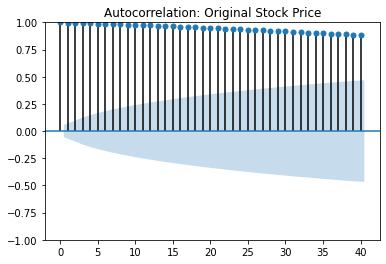

In [15]:
title = 'Autocorrelation: Original Stock Price'
lags = 40
plot_acf(df['Price'],title=title,lags=lags);

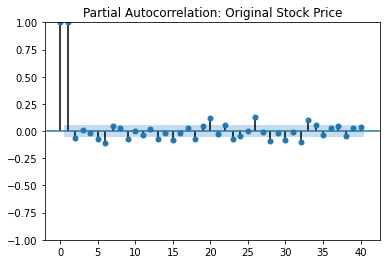

In [16]:
title = 'Partial Autocorrelation: Original Stock Price'
lags = 40
plot_pacf(df['Price'],title=title,lags=lags);

In [17]:
stepwise_fit = auto_arima(df['Price'], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19556.765, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19554.924, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19554.819, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19554.805, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19556.627, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.697 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1249
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -9776.402
Date:                Wed, 04 Jan 2023   AIC                          19554.805
Time:                        23:36:09   BIC                          19559.934
Sample:                             0   HQIC                         19556.733
                               - 1249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.727e+05   8332.811     44.731      0.000    3.56e+05    3.89e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.11   Jarque-Bera (JB):              1010.79
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               6.17   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [19]:
def split_data(data, test_split):
    length = len(data)
    size = round(length * (1 - test_split))
    train, test = data[:size], data[size:]
    print('train:', len(train))
    print('test:', len(test))
    return train, test

In [20]:
test_split = 0.1
train, test = split_data(df, test_split)

train: 1124
test: 125


In [21]:
model = sm.tsa.arima.ARIMA(train['Price'], order = (0,1,0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 1124
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -8776.982
Date:                Wed, 04 Jan 2023   AIC                          17555.963
Time:                        23:36:09   BIC                          17560.987
Sample:                             0   HQIC                         17557.862
                               - 1124                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.595e+05   7935.595     45.306      0.000    3.44e+05    3.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):              1318.56
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               5.77   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
start = len(train)
end = len(train) + len(test) -1
pred = model.predict(start = start, end = end, typ = 'levels').rename('ARIMA(0,1,0) Predictions')

print(pred)
pred.index = df.index[start: end + 1]

1124    25056.6
1125    25056.6
1126    25056.6
1127    25056.6
1128    25056.6
         ...   
1244    25056.6
1245    25056.6
1246    25056.6
1247    25056.6
1248    25056.6
Name: ARIMA(0,1,0) Predictions, Length: 125, dtype: float64


[Text(0, 0.5, 'Stock Price'), Text(0.5, 0, '')]

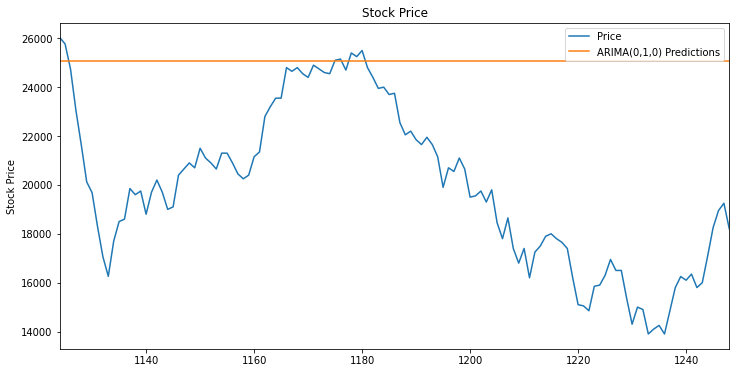

In [23]:
# Plot predictions against known values
title = 'Stock Price'
ylabel='Stock Price'
xlabel='' # we don't really need a label here

ax = test['Price'].plot(legend=True,figsize=(12,6),title=title)
pred.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)


In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

mse =  mean_squared_error(pred, test['Price'])
rmse = sqrt(mse)
mape = mean_absolute_percentage_error(pred, test['Price'])
print("RMSE: ", rmse)
print("MAPE: ", mape * 100)

RMSE:  6102.711752655536
MAPE:  20.751910474685307
